In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## Importing Data

In [4]:
data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Filling null values

In [18]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)


In [19]:
# Target Value count
data.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

## Creating Bar Chart for Target

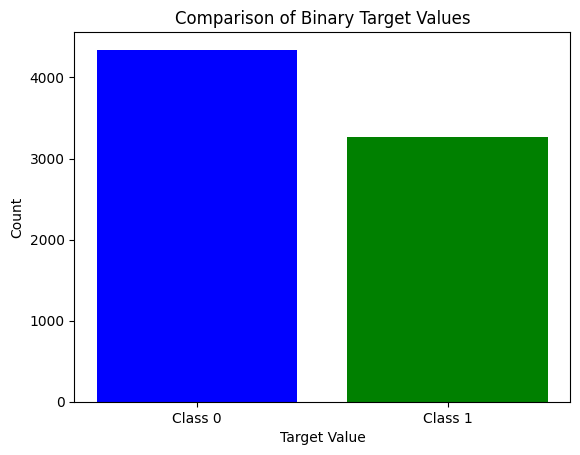

In [20]:
# Labels for the bar chart
labels = ['Class 0', 'Class 1']

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(labels, data.target.value_counts(), color=['blue', 'green'])

# Add titles and labels
ax.set_title('Comparison of Binary Target Values')
ax.set_xlabel('Target Value')
ax.set_ylabel('Count')

# Display the plot
plt.show()

## Preprocessing On Train data

In [21]:
# word count
data['word_count'] = data['text'].apply(lambda x: len(str(x).split(" ")))



# Avg word length
def word_len(text):
    words = text.split()
    return (sum(len(word) for word in words)/len(words))
data['avg_len'] = data['text'].apply(lambda x : word_len(x))



# # Count of Stop words e.g. i, am , are ,is
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['stopwords'] = data['text'].apply(lambda x: len([x for x in x.split() if x in stop]))




# No. of special characters 
data['hastags'] = data['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#') or x.startswith('@')]))




# Removing unneccesary char or words
import re
def preprocess1(text):
    text = text.lower()
    text = re.sub(r'http\S+','',text)
    text = re.sub(r'#','',text)
    text = re.sub(r'@','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\n+', ' ', text)
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1 and word.isalpha()]
    text = ' '.join(filtered_words)
    
    return text
text_data = data['text']
data['text'] = text_data.apply(preprocess1)




# Remove Stop words
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))




# Top 12000 Rare words
freq1 = pd.Series(' '.join(data['text']).split()).value_counts()[-12000:]
freq1 = list(freq1.index)
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq1))






import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

data['text'] = data['text'].apply(lambda x: lemmatize_text(x))
data.head()

,id,keyword,location,text,target,word_count,avg_len,stopwords,hastags
0,1,fatalities,USA,reason earthquake may allah we,1,13,4.384615,5,1
1,4,fatalities,USA,forest fire near la canada,1,7,4.571429,0,0
2,5,fatalities,USA,resident ask shelter place officer evacuation ...,1,22,5.090909,9,0
3,6,fatalities,USA,people wildfire evacuation order california,1,9,7.125000,1,1
4,7,fatalities,USA,get send photo alaska smoke wildfire school,1,17,4.500000,6,2


## Tried Various Sentiment Analysis Methods

### Vader Sentiment

In [278]:
# # Sentiment
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# analyzer = SentimentIntensityAnalyzer() # Initialize VADER sentiment analyzer
# def get_compound_score(text):
#     scores = analyzer.polarity_scores(text)
#     return scores['compound']

# data['sentiment'] = data['text'].apply(get_compound_score)
# data.head()

### Textblob Sentiment

In [279]:
# from textblob import TextBlob

# def get_polarity_score(text):
#     blob = TextBlob(text)
#     return blob.sentiment.polarity

# # Apply the function to the 'text' column and create a new 'sentiment' column
# data['sentiment2'] = data['text'].apply(get_polarity_score)

### Spacy Sentiment

In [22]:
import spacy
import pandas as pd
from transformers import pipeline

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize Hugging Face sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def get_sentiment(text):
    try:
        result = sentiment_pipeline(text)[0]
        # Return positive or negative score based on sentiment
        return result['score'] if result['label'] == 'POSITIVE' else -result['score']
    except Exception as e:
        print(f"Error processing text: {text}\nException: {e}")
        return None

# Apply the function to the 'text' column and create a new 'sentiment' column
data['sentiment3'] = data['text'].apply(get_sentiment)

2024-09-04 10:55:04.763019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 10:55:04.763180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 10:55:04.932821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Data After Preprocessing

In [23]:
data.head(5)

,id,keyword,location,text,target,word_count,avg_len,stopwords,hastags,sentiment3
0,1,fatalities,USA,reason earthquake may allah we,1,13,4.384615,5,1,-0.739920
1,4,fatalities,USA,forest fire near la canada,1,7,4.571429,0,0,-0.953385
2,5,fatalities,USA,resident ask shelter place officer evacuation ...,1,22,5.090909,9,0,-0.983510
3,6,fatalities,USA,people wildfire evacuation order california,1,9,7.125000,1,1,-0.994721
4,7,fatalities,USA,get send photo alaska smoke wildfire school,1,17,4.500000,6,2,-0.969642


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          7613 non-null   object 
 1   keyword     7613 non-null   object 
 2   location    7613 non-null   object 
 3   text        7613 non-null   object 
 4   target      7613 non-null   object 
 5   word_count  7613 non-null   int64  
 6   avg_len     7613 non-null   float64
 7   stopwords   7613 non-null   int64  
 8   hastags     7613 non-null   int64  
 9   sentiment3  7613 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 594.9+ KB


## Heatmap to See Correlation Among Features

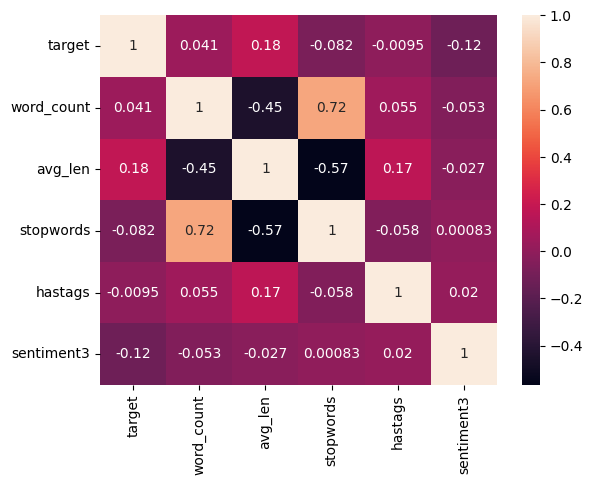

In [26]:
df = data.drop(['id','keyword','location','text'],axis=1)
df_cor = df.corr()
# Create heatmap
sns.heatmap(df_cor, annot=True)

# Show plot
plt.show()

# Preprocessing on Test data

In [27]:
# word count
test['word_count'] = test['text'].apply(lambda x: len(str(x).split(" ")))



# Avg word length
def word_len(text):
    words = text.split()
    return (sum(len(word) for word in words)/len(words))
test['avg_len'] = test['text'].apply(lambda x : word_len(x))



# Count of Stop words e.g. i, am , are ,is
from nltk.corpus import stopwords
stop = stopwords.words('english')

test['stopwords'] = test['text'].apply(lambda x: len([x for x in x.split() if x in stop]))




# No. of special characters 
test['hastags'] = test['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#') or x.startswith('@')]))




# Removing unneccesary char or words
text_data = test['text']
test['text'] = text_data.apply(preprocess1)




# Remove Stop words
test['text'] = test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))



# Lemmatize
test['text'] = test['text'].apply(lambda x: lemmatize_text(x))



freq1 = pd.Series(' '.join(test['text']).split()).value_counts()[-5000:]
freq1 = list(freq1.index)
test['text'] = test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq1))




# # Remove empty string
# test = test[test['text'].str.strip() != '']


# sentiment
test['sentiment3'] = test['text'].apply(get_sentiment)

## Test data After Preprocessing

In [28]:
test.head()

,id,keyword,location,text,word_count,avg_len,stopwords,hastags,sentiment3
0,0,deluged,New York,happen terrible car crash,6,4.833333,1,0,-0.999436
1,2,deluged,New York,hear earthquake different city stay safe everyone,9,6.222222,2,1,0.892609
2,3,deluged,New York,forest fire spot pond across street can not save,19,4.105263,8,0,-0.999212
3,9,deluged,New York,apocalypse light wildfire,4,9.250000,0,2,0.998466
4,11,deluged,New York,typhoon soudelor china taiwan,8,4.750000,2,0,-0.721158


In [29]:
x = data.drop(['id','keyword','location','target'], axis=1)
y = data['target']
y = y.astype(int)
test1 = test.drop(['id','location'], axis=1)

## Scaling the data

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

ct = ColumnTransformer([('sclaer', MaxAbsScaler(), ['word_count','avg_len','stopwords','hastags','sentiment3']),],remainder='drop')
#                        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'),['keyword'])

new_x = pd.DataFrame(ct.fit_transform(x))
new_x.head()

,0,1,2,3,4
0,0.240741,0.226790,0.277778,0.076923,-0.740002
1,0.129630,0.236453,0.000000,0.000000,-0.953491
2,0.407407,0.263323,0.500000,0.000000,-0.983620
3,0.166667,0.368534,0.055556,0.076923,-0.994832
4,0.314815,0.232759,0.333333,0.153846,-0.969750


In [31]:
new_test = pd.DataFrame(ct.transform(test1))
new_test.head()

,0,1,2,3,4
0,0.111111,0.250000,0.055556,0.000000,-0.999547
1,0.166667,0.321839,0.111111,0.076923,0.892709
2,0.351852,0.212341,0.444444,0.000000,-0.999324
3,0.074074,0.478448,0.000000,0.153846,0.998578
4,0.148148,0.245690,0.111111,0.000000,-0.721239


## Applying Vectorizer on Text data

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1,1))
train_vect = pd.DataFrame(tfidf.fit_transform(x['text']).toarray())
train_vect.head()

,0,1,2,3,4,5,6,7,8,9,...,3419,3420,3421,3422,3423,3424,3425,3426,3427,3428
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
test_vect = pd.DataFrame(tfidf.transform(test1['text']).toarray())
test_vect.head()

,0,1,2,3,4,5,6,7,8,9,...,3419,3420,3421,3422,3423,3424,3425,3426,3427,3428
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
transformed_x = pd.concat([new_x,train_vect],axis=1)
transformed_x.head()

,0,1,2,3,4,0,1,2,3,4,...,3419,3420,3421,3422,3423,3424,3425,3426,3427,3428
0,0.240741,0.226790,0.277778,0.076923,-0.740002,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.129630,0.236453,0.000000,0.000000,-0.953491,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.407407,0.263323,0.500000,0.000000,-0.983620,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166667,0.368534,0.055556,0.076923,-0.994832,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.314815,0.232759,0.333333,0.153846,-0.969750,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
transformed_test = pd.concat([new_test,test_vect],axis=1)
transformed_test.head()

,0,1,2,3,4,0,1,2,3,4,...,3419,3420,3421,3422,3423,3424,3425,3426,3427,3428
0,0.111111,0.250000,0.055556,0.000000,-0.999547,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.166667,0.321839,0.111111,0.076923,0.892709,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.351852,0.212341,0.444444,0.000000,-0.999324,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.074074,0.478448,0.000000,0.153846,0.998578,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.148148,0.245690,0.111111,0.000000,-0.721239,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection

In [36]:
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

# Prepare your feature matrix X and target vector y
X_non_negative = np.abs(transformed_x)  # Ensure non-negative values

# Convert target labels y to categorical if necessary
if not np.issubdtype(y.dtype, np.number):
    le = LabelEncoder()
    y = le.fit_transform(y)

# Perform feature selection
selector = SelectKBest(score_func=chi2, k=2000)
X_new = selector.fit_transform(X_non_negative, y)

print("Selected features:", X_new.shape)


Selected features: (7613, 2000)


In [37]:
Test_non_negative = np.abs(transformed_test)
test_new = selector.transform(Test_non_negative)

print("Selected features:", test_new.shape)

Selected features: (3263, 2000)


## Splitting Data for Validation

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, shuffle=True, random_state=42)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090, 2000), (1523, 2000), (6090,), (1523,))

## Tried various Models

In [43]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

pred_y = lr.predict(X_train)
pred_y_test = lr.predict(X_test)
print("training : ",f1_score(y_train, pred_y))
print("test : ",f1_score(y_test,pred_y_test))

training :  0.8123051340677614
test :  0.7613445378151259


In [49]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=100, random_state=42)
rfc.fit(X_train, y_train)

pred_y = rfc.predict(X_train)
pred_y_test = rfc.predict(X_test)
print("training : ",f1_score(y_train, pred_y))
print("test : ",f1_score(y_test,pred_y_test))

training :  0.9042353432088462
test :  0.7242290748898678


In [50]:
# pred_test=lr.predict(test_new)
# predictions_data=pd.DataFrame({'id':test['id'],'target':pred_test})
# predictions_data.to_csv('submission.csv',index=False)

In [52]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=500)
mlp.fit(X_train, y_train)

pred_y = mlp.predict(X_train)
pred_y_test = mlp.predict(X_test)
print("training : ",f1_score(y_train, pred_y))
print("test : ",f1_score(y_test,pred_y_test))

training :  0.9690563136651931
test :  0.722351121423047


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
pred_test=mlp.predict(test_new)
predictions_data=pd.DataFrame({'id':test['id'],'target':pred_test})
predictions_data.to_csv('submission.csv',index=False) 